<a href="https://colab.research.google.com/github/shivaansh81001/btc-prediction/blob/main/btc_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
path='/content/drive/MyDrive/btc predict/'

In [118]:
TABLE_NAME='btcusd_1-min_data.csv'
data=Table().read_table(path+TABLE_NAME)
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0


In [119]:
data= data.where("Timestamp",are.above_or_equal_to(1636520280))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.63652e+09,66991.5,66991.5,66935.9,66935.9,2.06704
1.63652e+09,66937.1,66945.7,66927.5,66945.7,0.130802
1.63652e+09,66928.4,66988.9,66928.4,66972.1,0.031246
1.63652e+09,66995.5,67014.5,66995.5,67014.5,0.0697985
1.63652e+09,67018.2,67123.4,67007.5,67123.4,1.64906


In [120]:
def format_price(price):
  split_=price.split(',')
  return float(split_[0]+split_[1])

def format_vol(vol):
  split_=float(vol[:-1])*1000
  return split_

def format_change(change):
  return float(change[:-1])

def format_time(time):
  time=int(time)
  return str(datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

def sum_volume(vol):
  return [sum(vol[i:i+60]) for i in range(2, len(vol), 60)]

In [121]:
volsum= sum_volume(list(data.column("Volume")))

In [122]:
#volsum len
print(len(volsum))

25896


In [123]:
#test format_price
print(format_price('95,284.5'))

#test format_vol
print(format_vol('61.62K'))

#test format_time
print(format_time(1734447660))

#vol sum
print(sum_volume([x for x in range(1,361)]))

95284.5
61620.0
2024-12-17 15:01:00
[1950, 5550, 9150, 12750, 16350, 19227]


In [124]:
formatted_time = data.apply(format_time,"Timestamp")
data = data.with_column("Timestamp",formatted_time)

data.show(5)

Timestamp,Open,High,Low,Close,Volume
2021-11-10 04:58:00,66991.5,66991.5,66935.9,66935.9,2.06704
2021-11-10 04:59:00,66937.1,66945.7,66927.5,66945.7,0.130802
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246
2021-11-10 05:01:00,66995.5,67014.5,66995.5,67014.5,0.0697985
2021-11-10 05:02:00,67018.2,67123.4,67007.5,67123.4,1.64906


In [126]:
data= data.take(np.arange(2,data.num_rows,60))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869


In [127]:
data = data.with_column("vol traded", np.array(volsum))

In [129]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246,43.442
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544


In [152]:
price_change_hourly= ((data.column("Close") - data.column("Open")) / data.column("Open")) *100
data = data.with_column("price_change_hourly",price_change_hourly)

In [157]:
data.sort("Timestamp",descending=True).show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly
2025-01-02 23:20:00,96816,96819,96793,96793,0.198558,2.97368,-0.0237564
2025-01-02 22:20:00,96800,96800,96775,96776,0.00391808,11.3632,-0.0247934
2025-01-02 21:20:00,97114,97114,97091,97091,0.0252511,14.8473,-0.0236835
2025-01-02 20:20:00,97703,97719,97676,97719,0.305568,18.0116,0.0163762
2025-01-02 19:20:00,97474,97499,97474,97491,0.156311,16.3315,0.0174405


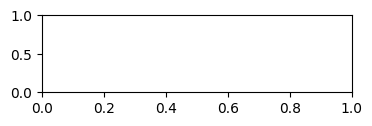

In [180]:
volume_change_hourly = data.to_df()['vol traded'].pct_change()*100
data = data.with_column("volume_change_hourly",volume_change_hourly)


In [181]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2021-11-10 05:00:00,66928.4,66988.9,66928.4,66972.1,0.031246,43.442,0.065204,nan
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884,0,-55.1392
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345,-0.0123943,17.1694
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226,-0.115937,217.163
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544,-0.00511045,-44.0032


In [185]:
data= data.exclude(0)
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2021-11-10 06:00:00,66951.4,66951.4,66951.4,66951.4,0.002,19.4884,0,-55.1392
2021-11-10 07:00:00,67047.1,67061.3,67038.8,67038.8,0.541149,22.8345,-0.0123943,17.1694
2021-11-10 08:00:00,66811.9,66836.1,66734.4,66734.4,0.337868,72.4226,-0.115937,217.163
2021-11-10 09:00:00,66530.3,66541.3,66526.9,66526.9,0.28869,40.5544,-0.00511045,-44.0032
2021-11-10 10:00:00,66649.7,66650,66643.5,66644.5,2.05988,27.0178,-0.00790701,-33.3789


In [130]:
'''%matplotlib inline

data.plot("Date","Price")

data.plot("Date","Change %")

data.scatter('Date',"Price")'''


'%matplotlib inline\n\ndata.plot("Date","Price")\n\ndata.plot("Date","Change %")\n\ndata.scatter(\'Date\',"Price")'

# new source #

In [131]:
news= Table.read_table(path+'cryptonews.csv').drop('url','source','title')
news = news.where("subject",are.equal_to("bitcoin"))
news.show(10)


date,sentiment,subject,text
2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subjectivity': ...",bitcoin,"Yonsei found that during BTC’s rally in early December, ..."
2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.1}",bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ..."
2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...
2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subjectivity': ...",bitcoin,The SEC has pushed back its decision on a roster of Ethe ...
2023-12-18 18:33:34,"{'class': 'negative', 'polarity': -0.27, 'subjectivity': ...",bitcoin,"Bitcoin may remain under pressure for a few days, but a ..."
2023-12-18 18:15:45,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,The ad spot came as the U.S. Securities and Exchange Com ...
2023-12-18 18:11:43,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.45}",bitcoin,"Bitcoin (BTC), the world's most valuable cryptocurrency, ..."
2023-12-18 17:55:00,"{'class': 'positive', 'polarity': 0.2, 'subjectivity': 0.7}",bitcoin,"Since the famous meme post to BitcoinTalk, Bitcoin (BTC) ..."
2023-12-18 17:01:00,"{'class': 'positive', 'polarity': 0.05, 'subjectivity': ...",bitcoin,"CoinShares said the ""mixed regional flows"" are more indi ..."
2023-12-18 15:42:27,"{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.2}",bitcoin,Digital asset mining firm Hut 8 signed an interim agreem ...


In [132]:
#test cell for sentiment
print(news.take(0).column("text")[0])

news.sort("date",descending=False).show(3)

Yonsei found that during BTC’s rally in early December, the Binary CDD was also active, signaling recent activity by short-term holders.


date,sentiment,subject,text
2021-11-10 04:58:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,"Bitcoin price is correcting gains below USD 67,000. Ethe ..."
2021-11-10 11:09:00,"{'class': 'negative', 'polarity': -0.02, 'subjectivity': ...",bitcoin,The much-awaited wallet is scheduled to be launched late ...
2021-11-10 13:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin price is struggling to gain momentum for a move ...


In [133]:
print(type(news.column("date").take(0)))

<class 'numpy.str_'>


In [134]:
def date_fix(date):
  return date[:-2]+'00'

In [135]:
#test date_fix
print(date_fix('2021-11-10 13:10:11'))

2021-11-10 13:10:00


In [136]:
class_ = []
polarity_ = []
subjectivity_ = []

for row in news.column("sentiment"):
  row=eval(row)
  if row['class']=='neutral':
    class_.append(0)
  elif row['class']=='negative':
    class_.append(-1)
  elif row['class']=='positive':
    class_.append(1)


  polarity_.append(row['polarity'])
  subjectivity_.append(row['subjectivity'])

class_,polarity_,subjectivity_=map(np.array,(class_,polarity_,subjectivity_))
print(class_,polarity_,subjectivity_)

fixed_date = news.apply(date_fix,'date')


news = news.with_columns("class",class_,"polarity",polarity_,"subjectivity",subjectivity_,"date",fixed_date).drop('sentiment')

news.sort("date",descending=True).show(5)



[-1  1  0 ...,  0 -1  0] [-0.01  0.3   0.   ...,  0.   -0.02  0.  ] [ 0.38  0.1   0.   ...,  0.    0.47  0.  ]


date,subject,text,class,polarity,subjectivity
2023-12-19 05:25:00,bitcoin,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0
2023-12-19 02:59:00,bitcoin,The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64
2023-12-18 18:33:00,bitcoin,"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33


In [137]:
news=news.drop("subject")

# Dataset created (news) #


In [138]:
created_sentiment= Table().read_table(path+'news_sent_analysis.csv')
created_sentiment.show(1)

title,newsDatetime,sentiment,polarity,subjectivity
"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",2017-11-12 15:00:00,1,-0.38,0.62


In [139]:
created_sentiment= created_sentiment.relabel("title","text")
created_sentiment= created_sentiment.relabel("newsDatetime","date")
created_sentiment= created_sentiment.relabel("sentiment","class")
created_sentiment= created_sentiment.move_to_start("date")
created_sentiment.show(1)

date,text,class,polarity,subjectivity
2017-11-12 15:00:00,"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",1,-0.38,0.62


# append news #

In [140]:
news= news.append(created_sentiment)
news.show(5)

date,text,class,polarity,subjectivity
2023-12-19 05:25:00,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0
2023-12-19 02:59:00,The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64
2023-12-18 18:33:00,"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33


In [141]:
#group test

news.group("text").sort("count",descending=True)

text,count
"Get your daily, bite-sized digest of cryptoasset and blo ...",165
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2


In [142]:
news=news.where("text",are.not_containing("Get your daily, bite-sized digest of cryptoasset and blo"))
news.group("text").sort("count",descending=True)

text,count
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2
"Since Jerome Powell's last appearance, the economic outl ...",2


In [143]:
temp_news = news.to_df()
temp_news = temp_news.drop_duplicates(subset=['text'])
news= Table().from_df(temp_news)

news.group("text").sort("count",descending=True)

text,count
"An automated, on-chain arbitrage strategy for Wrapped ...",1
#BTC4ALL drops next month! Read up on #MXC's game-cha ...,1
"#BTCB - #τBitcoin Vault: Stake $BTCB, Earn τBitcoin. ⏳ ...",1
#Bitcoin Cash @Utoday_en $BCH Potential to be legal ...,1
#Bitcoin Liquidations Lead $400M in Futures Losses Afte ...,1
#Bitcoin Transactions Surpass Visa according to new ana ...,1
#Bitcoin swaps are available in Klever Wallet Swap # ...,1
#CounosBit (#Cbits) is a new #hard_fork of the #Bitcoin ...,1
#CryptoTwitter What’s your #Bitcoin story?,1
"#Flux is at its heart about decentralization, it’s buil ...",1


In [144]:
news.show(3)

date,text,class,polarity,subjectivity
2023-12-19 05:25:00,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0


# merge #

In [145]:
merged_table = news.join("date",data,"Timestamp")
merged_table.show(5)

date,text,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded
2021-11-11 20:00:00,An Unrealized Capital Gains Tax Would Wallop Big Stock A ...,-1,0,0.1,65165.6,65194.9,65123,65194.9,0.226378,43.7905
2021-11-11 21:00:00,"The watchdog says it believes there is a USD 9,347 discr ...",0,0,0,64840,64870.1,64821.8,64870.1,0.569077,82.3354
2021-11-12 18:00:00,The think tank says its latest survey shows that certain ...,1,0.24,0.82,63837.8,63837.8,63764.8,63775.6,0.986303,197.648
2021-11-15 22:00:00,"The official, the investigators stated, \x9caccepted gif ...",0,0,0,64186.3,64273.5,64131.1,64251.5,0.764056,32.5564
2021-11-16 17:00:00,Russian lawmakers and regulators are pressing for crypto ...,0,0,0,60590.8,60590.8,60545.9,60565.4,3.43147,169.433


In [146]:
merged_table = merged_table.drop('bitcoin','text','title','subject')


In [147]:
merged_table.show(5)

date,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded
2021-11-11 20:00:00,-1,0,0.1,65165.6,65194.9,65123,65194.9,0.226378,43.7905
2021-11-11 21:00:00,0,0,0,64840,64870.1,64821.8,64870.1,0.569077,82.3354
2021-11-12 18:00:00,1,0.24,0.82,63837.8,63837.8,63764.8,63775.6,0.986303,197.648
2021-11-15 22:00:00,0,0,0,64186.3,64273.5,64131.1,64251.5,0.764056,32.5564
2021-11-16 17:00:00,0,0,0,60590.8,60590.8,60545.9,60565.4,3.43147,169.433


# Stats #

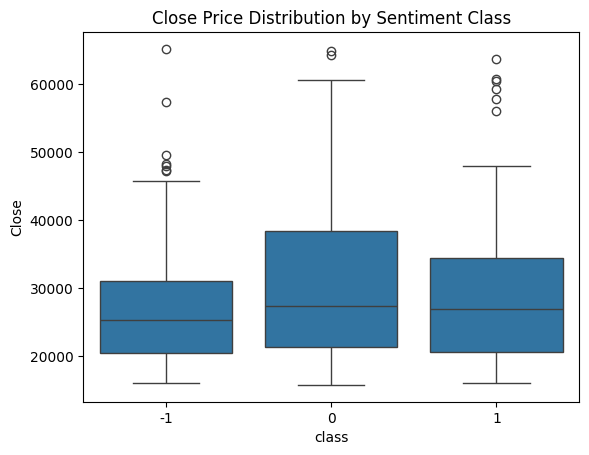

In [148]:
%matplotlib inline
import seaborn as sns

df= merged_table.to_df()
sns.boxplot(x='class', y='Close', data=df)
plt.title('Close Price Distribution by Sentiment Class')
plt.show()

In [149]:
downsample_rate = 50
date=df['date'][::downsample_rate]
polarity=df['polarity'][::downsample_rate]
close=df['Close'][::downsample_rate]

<function matplotlib.pyplot.show(close=None, block=None)>

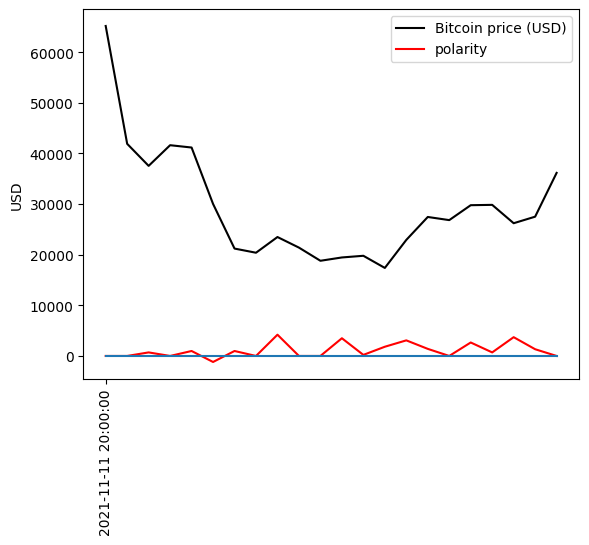

In [150]:
plt.figure()
plt.plot(date,close,'k',label = 'Bitcoin price (USD)')
plt.plot(date,7000*polarity,'r',label = 'polarity')
plt.plot(date,np.zeros(len(date)))
plt.ylabel('USD')
plt.xticks(date[::100],rotation='vertical')
plt.legend()
plt.show

In [151]:
from scipy.stats import f_oneway

negative = df[df['class'] == -1]['Close']
neutral = df[df['class'] == 0]['Close']
positive = df[df['class'] == 1]['Close']

stat, p_value = f_oneway(negative, neutral, positive)

print(f"ANOVA Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Significant difference in Close Price across sentiment classes.")
else:
    print("No significant difference in Close Price across sentiment classes.")

ANOVA Statistic: 3.4356155264119446, p-value: 0.03255929949933639
Significant difference in Close Price across sentiment classes.
